In [411]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [412]:
df = pd.read_parquet('../data/credit/model_df.parquet')

In [413]:
df = df.drop(['ID', 'target_heuristic'], axis=1)

In [414]:
cut = df['vintage'].quantile(0.7)

train = df[df['vintage'] < cut]
test = df[df['vintage'] >= cut]

In [415]:
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

In [416]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos

In [417]:
model = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

In [418]:
print(classification_report(y_test, pred))
print(roc_auc_score(y_test, proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6949
           1       0.97      0.76      0.85        41

    accuracy                           1.00      6990
   macro avg       0.98      0.88      0.92      6990
weighted avg       1.00      1.00      1.00      6990

0.8725873875518149


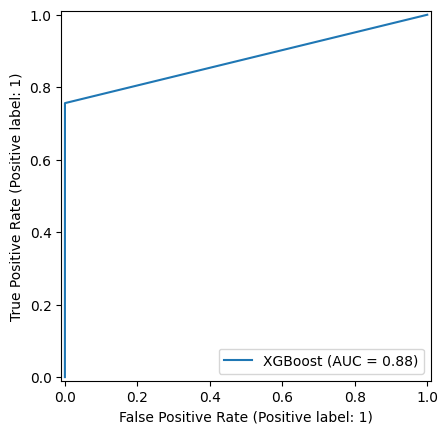

In [419]:
RocCurveDisplay.from_predictions(y_test, pred, name='XGBoost');

In [420]:
importancia = pd.DataFrame({'colunas': X_train.columns, 'importancia': model.feature_importances_}).sort_values(by='importancia', ascending=False)
importancia

,colunas,importancia
17,max_status,0.336178
9,NAME_HOUSING_TYPE,0.068715
10,OCCUPATION_TYPE,0.065769
7,NAME_EDUCATION_TYPE,0.054358
15,unclassified_occupation,0.048855
0,CODE_GENDER,0.046191
11,years_employed,0.043749
16,vintage,0.042575
6,NAME_INCOME_TYPE,0.038509
13,renda_per_capita,0.037308


In [421]:
importancia10 = importancia.sort_values(by='importancia', ascending=False).head(10)

C:\Users\gui-s\AppData\Local\Temp\ipykernel_3760\1473848680.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75)


[Text(0, 0, 'max_status'),
 Text(1, 0, 'NAME_HOUSING_TYPE'),
 Text(2, 0, 'OCCUPATION_TYPE'),
 Text(3, 0, 'NAME_EDUCATION_TYPE'),
 Text(4, 0, 'unclassified_occupation'),
 Text(5, 0, 'CODE_GENDER'),
 Text(6, 0, 'years_employed'),
 Text(7, 0, 'vintage'),
 Text(8, 0, 'NAME_INCOME_TYPE'),
 Text(9, 0, 'renda_per_capita')]

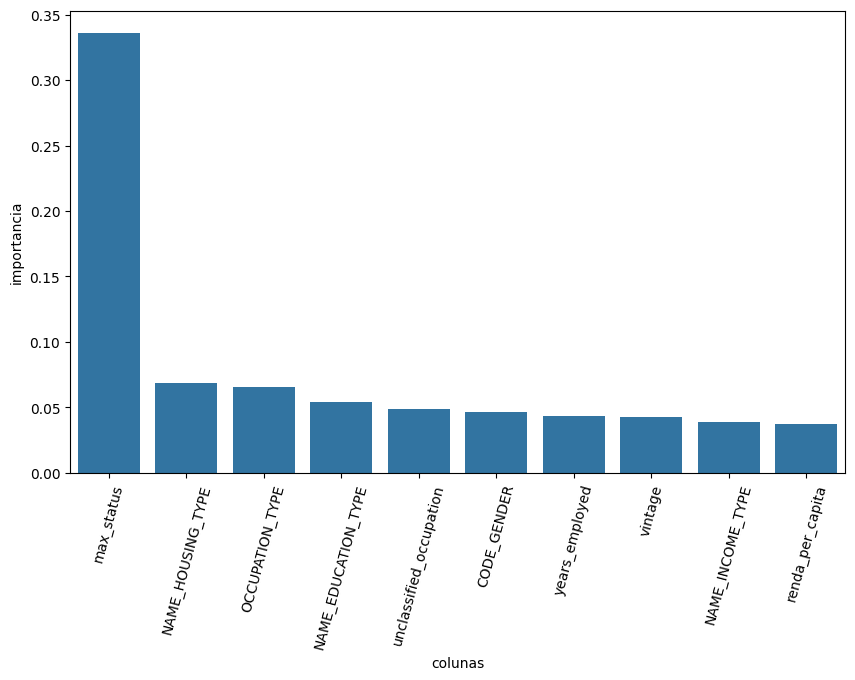

In [422]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='colunas', y='importancia', data=importancia10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)

In [423]:
X_train = X_train.drop(columns=['vintage', 'no_formal_employment'])
X_test = X_test.drop(columns=['vintage', 'no_formal_employment'])

In [424]:
model = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

In [425]:
print(classification_report(y_test, pred))
print(roc_auc_score(y_test, proba))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6949
           1       0.33      0.76      0.46        41

    accuracy                           0.99      6990
   macro avg       0.66      0.87      0.73      6990
weighted avg       0.99      0.99      0.99      6990

0.8921936477963139


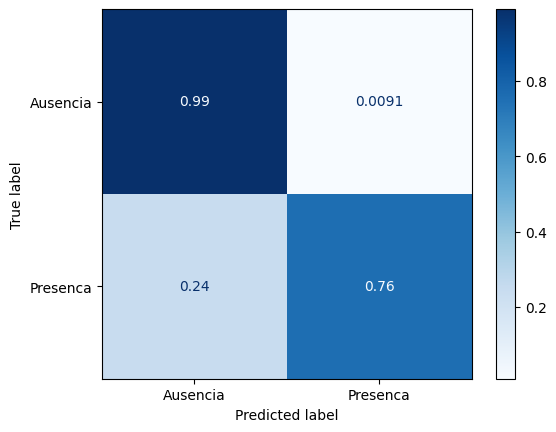

In [426]:

ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Ausencia', 'Presenca'], normalize='true', cmap='Blues');

In [427]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

# 🧠 Treinamento Inicial e Avaliação do Modelo

## 🎯 Objetivo

Esta etapa tem como objetivo treinar um modelo inicial de classificação binária para previsão de inadimplência, avaliar seu desempenho e analisar a relevância das variáveis utilizadas.

O foco é validar a qualidade das features antes da definição do modelo final.

---

## 🧹 Preparação dos Dados

Remoção de colunas que não devem ser utilizadas como preditoras:

```python
df = df.drop(['ID', 'target_heuristic'], axis=1)
```

---

## ✂️ Separação Temporal (Baseada em Vintage)

A divisão entre treino e teste foi realizada com base na variável `vintage`, respeitando a ordem temporal.

```python
cut = df['vintage'].quantile(0.7)

train = df[df['vintage'] < cut]
test = df[df['vintage'] >= cut]
```

Essa abordagem evita vazamento temporal (*data leakage*).

---

## 📦 Separação de Variáveis

Definição de variáveis independentes e target:

```python
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']
```

---

## ⚖️ Balanceamento de Classes

Devido ao desbalanceamento da variável resposta, foi utilizado `scale_pos_weight`:

```python
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
```

Esse parâmetro ajusta o peso da classe minoritária durante o treinamento.

---

## 🤖 Treinamento do Modelo Base (XGBoost)

Foi utilizado o classificador XGBoost com suporte a variáveis categóricas:

```python
model = xgb.XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight
)

model.fit(X_train, y_train)
```

---

## 📈 Geração de Previsões

```python
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]
```

---

## 📊 Avaliação de Desempenho

### Classification Report

```python
print(classification_report(y_test, pred))
```

Métricas avaliadas:

- Precision
- Recall
- F1-score
- Accuracy

---

### AUC-ROC

```python
print(roc_auc_score(y_test, proba))
```

Indicador da capacidade discriminatória do modelo.

---

### Curva ROC

```python
RocCurveDisplay.from_predictions(
    y_test,
    pred,
    name='XGBoost'
)
```

---

## 🔍 Importância das Variáveis

Extração da importância das features:

```python
importancia = pd.DataFrame({
    'colunas': X_train.columns,
    'importancia': model.feature_importances_
}).sort_values(by='importancia', ascending=False)
```

---

### Top 10 Variáveis

```python
importancia10 = importancia.head(10)
```

---

### Visualização

```python
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='colunas',
    y='importancia',
    data=importancia10
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=75
)
```

---

## 🧪 Ajuste de Features

Com base na análise de importância, foram removidas variáveis com baixa relevância:

```python
X_train = X_train.drop(columns=['vintage', 'no_formal_employment'])
X_test = X_test.drop(columns=['vintage', 'no_formal_employment'])
```

---

## 🔄 Retreinamento

Após a remoção das variáveis, o modelo foi re-treinado:

```python
model = xgb.XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight
)

model.fit(X_train, y_train)
```

---

## 📉 Avaliação Pós-Ajuste

### Classification Report

```python
print(classification_report(y_test, pred))
print(roc_auc_score(y_test, proba))
```

---

### Matriz de Confusão

```python
ConfusionMatrixDisplay.from_predictions(
    y_test,
    pred,
    display_labels=['Ausencia', 'Presenca'],
    normalize='true',
    cmap='Blues'
)
```

A matriz foi normalizada para facilitar a interpretação.

---

## ✅ Resultado

Esta etapa permitiu:

- Validar a qualidade das features
- Avaliar estabilidade do modelo
- Identificar variáveis mais relevantes
- Realizar ajustes iniciais
- Preparar o modelo para otimização final


In [428]:
params = {'objective': 'binary:logistic', 'eval_metric': ['auc', 'aucpr']}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=500, early_stopping_rounds=5,as_pandas=True, seed=42)

print(cv_results)
print("AUC CV:", cv_results["test-auc-mean"].iloc[-1])
print("AUCPR CV:", cv_results["test-aucpr-mean"].iloc[-1])

   train-auc-mean  train-auc-std  train-aucpr-mean  train-aucpr-std  \
0        0.861729       0.028500          0.158616         0.002483   
1        0.881139       0.008412          0.468877         0.025899   
2        0.905263       0.006136          0.513452         0.028760   
3        0.916106       0.011894          0.531330         0.019518   
4        0.934055       0.007951          0.545892         0.022452   
5        0.944369       0.005110          0.559527         0.023183   
6        0.949284       0.004997          0.567050         0.025954   
7        0.954287       0.007980          0.575893         0.025333   

   test-auc-mean  test-auc-std  test-aucpr-mean  test-aucpr-std  
0       0.734538      0.043951         0.138270        0.013981  
1       0.739228      0.045781         0.425326        0.077975  
2       0.732361      0.043137         0.433989        0.077478  
3       0.736373      0.031932         0.435181        0.081746  
4       0.729356      0.031554

In [429]:
params = {
    'objective': 'binary:logistic', 
    'eval_metric': ['auc', 'aucpr'],
    'max_depth': 3,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8
    }

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=500, early_stopping_rounds=5,as_pandas=True, seed=42)

print(cv_results)
print("AUC CV:", cv_results["test-auc-mean"].iloc[-1])
print("AUCPR CV:", cv_results["test-aucpr-mean"].iloc[-1])

    train-auc-mean  train-auc-std  train-aucpr-mean  train-aucpr-std  \
0         0.799582       0.027987          0.148221         0.005573   
1         0.817165       0.025169          0.162933         0.010376   
2         0.824254       0.022958          0.271614         0.123483   
3         0.825763       0.021330          0.455288         0.049026   
4         0.825351       0.022296          0.467145         0.045805   
5         0.826216       0.023706          0.469996         0.042792   
6         0.826082       0.023651          0.472866         0.042466   
7         0.824785       0.021968          0.474768         0.043414   
8         0.826457       0.020916          0.476566         0.042818   
9         0.829372       0.021117          0.476288         0.042067   
10        0.829798       0.020841          0.478219         0.041404   
11        0.833866       0.018957          0.478884         0.041106   
12        0.835380       0.017611          0.478959         0.04

In [430]:
tscv = TimeSeriesSplit(n_splits=3)

params= {
    "max_depth": [2,3,4,5],
    "min_child_weight": [5,10,20],
    "gamma": [0, 0.1, 0.3],

    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],

    "learning_rate": [0.01, 0.03, 0.05],
    "n_estimators": [300, 600, 900],

    "reg_alpha": [0, 0.3, 0.7],
    "reg_lambda": [1, 3, 5]
}

model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight, random_state=42, enable_categorical=True)

random_search_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=40,
    scoring={
        "auc": "roc_auc",
        "recall": "recall"
    },
    refit="auc",
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

random_search_cv.fit(X_train, y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [2, 3, ...], ...}"
,n_iter,40
,scoring,"{'auc': 'roc_auc', 'recall': 'recall'}"
,n_jobs,-1
,refit,'auc'
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [431]:
results = pd.DataFrame(random_search_cv.cv_results_)
best_idx = random_search_cv.best_index_
print("Best AUC CV:", random_search_cv.best_score_)
print("Recall CV do melhor AUC:", results.loc[best_idx, "mean_test_recall"])
print('Melhores Parâmetros encontrados:', random_search_cv.best_params_)


Best AUC CV: 0.7408218526919411
Recall CV do melhor AUC: 0.4305555555555556
Melhores Parâmetros encontrados: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0.7, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [432]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    subsample=0.9,
    reg_lambda=5,
    reg_alpha=0.3,
    n_estimators=600,
    min_child_weight=20,
    max_depth=2,
    learning_rate=0.01,
    colsample_bytree=0.8,
    gamma=0,
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight,
)
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

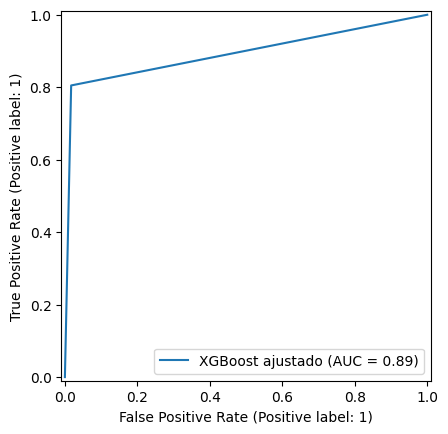

In [433]:
RocCurveDisplay.from_predictions(y_test, pred, name='XGBoost ajustado')

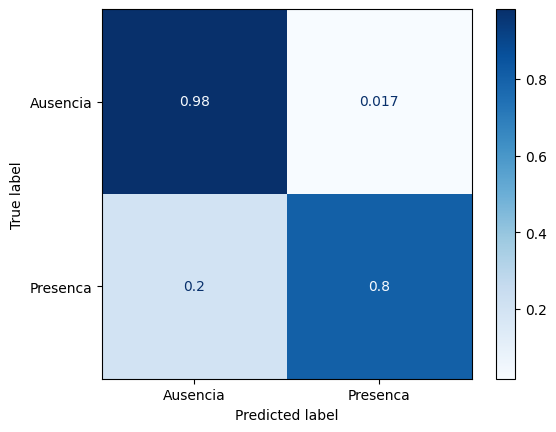

In [434]:
ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Ausencia', 'Presenca'], normalize='true', cmap='Blues')

In [435]:
thresholds = np.arange(0.05, 1, 0.05)

rows = []

for t in thresholds:
    pred_t = (proba >= t).astype(int)

    rep = classification_report(
        y_test,
        pred_t,
        output_dict=True,
        zero_division=0
    )

    rows.append({
        "t": t,
        "recall": rep["1"]["recall"],
        "precision": rep["1"]["precision"],
        "f1": rep["1"]["f1-score"]
    })

pd.DataFrame(rows)


,t,recall,precision,f1
0,0.05,1.000000,0.005866,0.011663
1,0.10,1.000000,0.005870,0.011671
2,0.15,1.000000,0.005969,0.011867
3,0.20,0.951220,0.006400,0.012714
4,0.25,0.926829,0.007637,0.015148
5,0.30,0.926829,0.010644,0.021047
6,0.35,0.878049,0.017266,0.033866
7,0.40,0.853659,0.040509,0.077348
8,0.45,0.829268,0.096317,0.172589
9,0.50,0.804878,0.215686,0.340206


In [436]:
t = 0.65

proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= t).astype(int)

print(classification_report(y_test, pred))
print("AUC:", roc_auc_score(y_test, proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6949
           1       0.72      0.80      0.76        41

    accuracy                           1.00      6990
   macro avg       0.86      0.90      0.88      6990
weighted avg       1.00      1.00      1.00      6990

AUC: 0.912247419351442


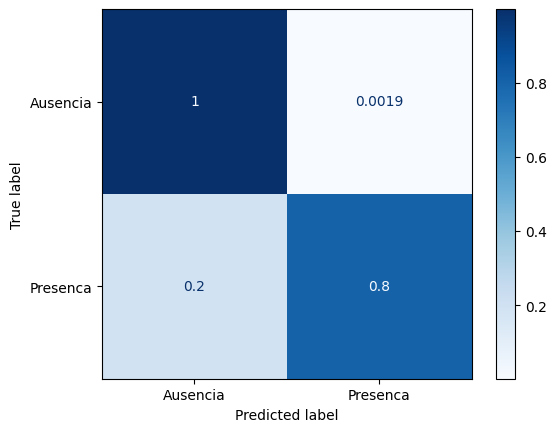

In [437]:
ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Ausencia', 'Presenca'], normalize='true', cmap='Blues')

In [438]:


# ===== TRAIN =====
proba_train = model.predict_proba(X_train)[:,1]
pred_train = (proba_train >= t).astype(int)

auc_train = roc_auc_score(y_train, proba_train)

print("=== TRAIN ===")
print(classification_report(y_train, pred_train))
print("AUC train:", auc_train)


# ===== TEST =====
proba_test = model.predict_proba(X_test)[:,1]
pred_test = (proba_test >= t).astype(int)

auc_test = roc_auc_score(y_test, proba_test)

print("\n=== TEST ===")
print(classification_report(y_test, pred_test))
print("AUC test:", auc_test)

print("\nGAP AUC:", auc_train - auc_test)

#Modelo Final


=== TRAIN ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15110
           1       0.25      0.50      0.34       134

    accuracy                           0.98     15244
   macro avg       0.63      0.74      0.66     15244
weighted avg       0.99      0.98      0.99     15244

AUC train: 0.9050500311151062

=== TEST ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6949
           1       0.72      0.80      0.76        41

    accuracy                           1.00      6990
   macro avg       0.86      0.90      0.88      6990
weighted avg       1.00      1.00      1.00      6990

AUC test: 0.912247419351442

GAP AUC: -0.0071973882363358666


# 🏁 Otimização, Validação e Definição do Modelo Final

## 🎯 Objetivo

Esta etapa tem como objetivo otimizar os hiperparâmetros do modelo XGBoost, avaliar sua estabilidade por validação cruzada, definir o threshold de decisão e validar a generalização entre treino e teste.

---

## 🔁 Validação Cruzada com XGBoost

Inicialmente, foi aplicada validação cruzada utilizando a função nativa do XGBoost.

```python
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'aucpr'],
    'max_depth': 3,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8
}

cv_results = xgb.cv(
    dtrain=dtrain,
    params=params,
    nfold=3,
    num_boost_round=500,
    early_stopping_rounds=5,
    as_pandas=True,
    seed=42
)
```

Foram monitoradas as métricas AUC e AUC-PR para avaliar desempenho e convergência.

---

## 🎛️ Otimização de Hiperparâmetros

Foi aplicada busca aleatória com validação cruzada:

```python
params = {
    "max_depth": [2,3,4,5],
    "min_child_weight": [5,10,20],
    "gamma": [0, 0.1, 0.3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "learning_rate": [0.01, 0.03, 0.05],
    "n_estimators": [300, 600, 900],
    "reg_alpha": [0, 0.3, 0.7],
    "reg_lambda": [1, 3, 5]
}
```

```python
random_search_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=40,
    scoring={
        "auc": "roc_auc",
        "recall": "recall"
    },
    refit="auc",
    cv=tscv,
    verbose=2,
    n_jobs=-1
)
```

---

## 🏆 Seleção dos Melhores Parâmetros

Após a otimização:

```python
print(random_search_cv.best_score_)
print(random_search_cv.best_params_)
```

Os parâmetros selecionados foram utilizados no modelo final.

---

## 🤖 Treinamento do Modelo Otimizado

```python
model = xgb.XGBClassifier(
    objective='binary:logistic',
    subsample=0.9,
    reg_lambda=5,
    reg_alpha=0.3,
    n_estimators=600,
    min_child_weight=20,
    max_depth=2,
    learning_rate=0.01,
    colsample_bytree=0.8,
    gamma=0,
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight
)

model.fit(X_train, y_train)
```

---

## 📈 Avaliação com Curva ROC

```python
RocCurveDisplay.from_predictions(
    y_test,
    pred,
    name='XGBoost ajustado'
)
```

A curva ROC foi utilizada para avaliar a capacidade discriminatória do modelo.

---

## 📊 Matriz de Confusão

```python
ConfusionMatrixDisplay.from_predictions(
    y_test,
    pred,
    display_labels=['Ausencia', 'Presenca'],
    normalize='true',
    cmap='Blues'
)
```

A matriz foi normalizada para facilitar interpretação.

---

## 🎯 Análise de Threshold

Foi realizada avaliação do impacto do threshold na performance:

```python
thresholds = np.arange(0.05, 1, 0.05)

for t in thresholds:
    pred_t = (proba >= t).astype(int)
```

Para cada threshold foram calculados:

- Precision
- Recall
- F1-score

---

## ⚖️ Definição do Threshold Final

O threshold selecionado foi:

```python
t = 0.65
```

Aplicação:

```python
pred = (proba >= t).astype(int)
```

Esse valor apresentou o melhor equilíbrio entre recall e precisão.

---

## 📉 Avaliação Final

### Teste

```python
print(classification_report(y_test, pred))
print(roc_auc_score(y_test, proba))
```

Resultados:

- AUC ≈ 0.91
- Recall positivo ≈ 0.80
- Precision positivo ≈ 0.72

---

### Treino vs Teste

```python
print("AUC train:", auc_train)
print("AUC test:", auc_test)
print("GAP:", auc_train - auc_test)
```

Foi observado baixo gap entre treino e teste, indicando boa generalização.

---

## 🧠 Análise de Overfitting

O pequeno gap de AUC indica:

- Baixo overfitting
- Estabilidade do modelo
- Boa capacidade preditiva

---

## ✅ Resultado

Ao final desta etapa, foi definido um modelo otimizado, validado e calibrado, com:

- Hiperparâmetros ajustados
- Threshold definido
- Boa generalização
- Métricas consistentes

Este modelo foi adotado como versão final para o sistema de crédito.


In [439]:
def fit_score_scale(p1, s1, p2, s2):
    # p -> odds
    o1 = p1 / (1 - p1)
    o2 = p2 / (1 - p2)

    # Score = A - B*ln(odds)
    # s1 = A - B ln(o1)
    # s2 = A - B ln(o2)
    B = (s1 - s2) / (np.log(o2) - np.log(o1))
    A = s1 + B * np.log(o1)
    return A, B

def proba_to_score(p, A, B, clip_min=300, clip_max=850):
    p = np.clip(p, 1e-6, 1-1e-6)
    odds = p / (1 - p)
    score = A - B * np.log(odds)
    return np.clip(score, clip_min, clip_max)

p_reprova, s_reprova = 0.90, 350
p_aprova,  s_aprova  = 0.05, 850

A, B = fit_score_scale(p_reprova, s_reprova, p_aprova, s_aprova)

# aplicar
df_result = X_test.copy()
df_result["proba_bad"] = model.predict_proba(X_test)[:, 1]
df_result["score"] = proba_to_score(df_result["proba_bad"], A, B)

df_result["score"].describe()


count    6990.000000
mean      645.949341
std        48.141006
min       300.000000
25%       618.677261
50%       644.921875
75%       674.563843
max       785.251343
Name: score, dtype: float64

In [ ]:
# Números comuns do négocio
score_cuts = {
    "q90": 750, "q70": 650, "q40": 570, "q15": 450,
    "cut_reprovado": 450, "cut_manual": 570, "cut_restricao": 650
}

In [441]:
def rating(s):
    if s >= score_cuts["q90"]:
        return "A - Excelente"
    elif s >= score_cuts["q70"]:
        return "B - Bom"
    elif s >= score_cuts["q40"]:
        return "C - Regular"
    elif s >= score_cuts["q15"]:
        return "D - Risco"
    else:
        return "E - Alto Risco"

df_result["rating"] = df_result["score"].apply(rating)
df_result["rating"].value_counts()


rating
C - Regular       3755
B - Bom           3112
E - Alto Risco      46
A - Excelente       41
D - Risco           36
Name: count, dtype: int64

In [442]:
def decision_by_score(s):
    if s < score_cuts["cut_reprovado"]:
        return "Reprovado"
    elif s < score_cuts["cut_manual"]:
        return "Análise Manual"
    elif s < score_cuts["cut_restricao"]:
        return "Aprovado com Restrição"
    else:
        return "Aprovado"


In [443]:
df_result["decision"] = df_result["score"].apply(decision_by_score)
df_result["decision"].value_counts()


decision
Aprovado com Restrição    3755
Aprovado                  3153
Reprovado                   46
Análise Manual              36
Name: count, dtype: int64

In [444]:
pct_decisao = df_result["decision"].value_counts(normalize=True)

pct_aprovado = pct_decisao.get("Aprovado", 0)
pct_restricao = pct_decisao.get("Aprovado com Restrição", 0)
pct_manual = pct_decisao.get("Análise Manual", 0)
pct_reprovado = pct_decisao.get("Reprovado", 0)

# Aprovação total
aprov_total = pct_aprovado + pct_restricao

In [464]:
import numpy as np

LGD = 0.60  # cenário base

# 1) Se você já tiver EAD:
# df_result["EAD"] = df_result["credit_limit"]

# 2) Se NÃO tiver: criar um proxy (ex.: 3x renda mensal)
df_result["EAD"] = df_result["amt_income_month"] * 3

# PD anual (12m) vindo do modelo
df_result["PD_12m"] = df_result["proba_bad"]

# Perda esperada anual
df_result["EL_12m"] = df_result["PD_12m"] * LGD * df_result["EAD"]

# Perda esperada mensal (aprox)
df_result["EL_mensal"] = df_result["EL_12m"] / 12

# KPIs do portfólio
EL_mensal_total = df_result["EL_mensal"].sum()
EL_12m_total = df_result["EL_12m"].sum()

print("EL mensal total:", EL_mensal_total)
print("EL 12m total:", EL_12m_total)


EL mensal total: 2913.262906445133
EL 12m total: 34959.1548773416


# 🧮 Score de Crédito (Escala) + Rating + Decisão

## 🎯 Objetivo

Transformar a probabilidade prevista pelo modelo (`proba_bad`) em um **score numérico padronizado**, além de gerar:

- **Rating** (faixas A–E)
- **Decisão** (Aprovado / Restrição / Manual / Reprovado)

---

## 🔁 Conversão de Probabilidade → Odds → Score

A escala segue a forma padrão:

```text
odds = p / (1 - p)
score = A - B * ln(odds)
```

Onde:

- `p` é a probabilidade de inadimplência (`proba_bad`)
- `A` e `B` são parâmetros calibrados por duas âncoras (pontos conhecidos)

---

## 🧷 Calibração dos Parâmetros (A e B)

A função abaixo estima `A` e `B` usando dois pontos de referência:

```python
def fit_score_scale(p1, s1, p2, s2):
    # p -> odds
    o1 = p1 / (1 - p1)
    o2 = p2 / (1 - p2)

    # Score = A - B*ln(odds)
    # s1 = A - B*ln(o1)
    # s2 = A - B*ln(o2)
    B = (s1 - s2) / (np.log(o2) - np.log(o1))
    A = s1 + B * np.log(o1)
    return A, B
```

Âncoras definidas:

```python
p_reprova, s_reprova = 0.90, 350
p_aprova,  s_aprova  = 0.05, 850

A, B = fit_score_scale(p_reprova, s_reprova, p_aprova, s_aprova)
```

Interpretação:

- Clientes com `p ≈ 0.90` tendem a score baixo (~350)
- Clientes com `p ≈ 0.05` tendem a score alto (~850)

---

## 🧮 Função de Conversão (com Clipping)

Para garantir estabilidade numérica e limitar a faixa final do score:

```python
def proba_to_score(p, A, B, clip_min=300, clip_max=850):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    odds = p / (1 - p)
    score = A - B * np.log(odds)
    return np.clip(score, clip_min, clip_max)
```

---

## 🧾 Aplicação no Conjunto de Teste

```python
df_result = X_test.copy()
df_result["proba_bad"] = model.predict_proba(X_test)[:, 1]
df_result["score"] = proba_to_score(df_result["proba_bad"], A, B)
```

---

## 🧱 Faixas de Score (Rating)

Definição de cortes para classificação A–E:

```python
score_cuts = {
    "q90": 750, "q70": 650, "q40": 570, "q15": 450,
    "cut_reprovado": 450, "cut_manual": 570, "cut_restricao": 650
}
```

Função de rating:

```python
def rating(s):
    if s >= score_cuts["q90"]:
        return "A - Excelente"
    elif s >= score_cuts["q70"]:
        return "B - Bom"
    elif s >= score_cuts["q40"]:
        return "C - Regular"
    elif s >= score_cuts["q15"]:
        return "D - Risco"
    else:
        return "E - Alto Risco"
```

Aplicação:

```python
df_result["rating"] = df_result["score"].apply(rating)
df_result["rating"].value_counts()
```

---

## ✅ Regra de Decisão (Aprovação)

Função de decisão baseada em score:

```python
def decision_by_score(s):
    if s < score_cuts["cut_reprovado"]:
        return "Reprovado"
    elif s < score_cuts["cut_manual"]:
        return "Análise Manual"
    elif s < score_cuts["cut_restricao"]:
        return "Aprovado com Restrição"
    else:
        return "Aprovado"
```

Aplicação:

```python
df_result["decision"] = df_result["score"].apply(decision_by_score)
df_result["decision"].value_counts()
```

---

## ✅ Resultado

Ao final desta etapa, o pipeline gera automaticamente para cada cliente:

- `proba_bad` (probabilidade prevista)
- `score` (faixa 350–850)
- `rating` (A–E)
- `decision` (Reprovado / Manual / Restrição / Aprovado)


In [ ]:
# ------------------------------------------------------------
# 1) Utils: Score scale + regras de negócio
# ------------------------------------------------------------
def fit_score_scale(p1, s1, p2, s2):
    o1 = p1 / (1 - p1)
    o2 = p2 / (1 - p2)
    B = (s1 - s2) / (np.log(o2) - np.log(o1))
    A = s1 + B * np.log(o1)
    return A, B


def proba_to_score(p, A, B, clip_min=300, clip_max=850):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    odds = p / (1 - p)
    s = A - B * np.log(odds)
    return np.clip(s, clip_min, clip_max)


def rating(score, cuts):
    if score >= cuts["q90"]:
        return "A - Excelente"
    elif score >= cuts["q70"]:
        return "B - Bom"
    elif score >= cuts["q40"]:
        return "C - Regular"
    elif score >= cuts["q15"]:
        return "D - Risco"
    else:
        return "E - Alto Risco"


def decision_by_score(score, cuts):
    if score < cuts["cut_reprovado"]:
        return "Reprovado"
    elif score < cuts["cut_manual"]:
        return "Análise Manual"
    elif score < cuts["cut_restricao"]:
        return "Aprovado com Restrição"
    else:
        return "Aprovado"


# ------------------------------------------------------------
# 2) Transformers / Estimator
# ------------------------------------------------------------
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop=None):
        self.cols_to_drop = cols_to_drop or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        cols = [c for c in self.cols_to_drop if c in X.columns]
        return X.drop(columns=cols, errors="ignore")


class EnsureCategorical(BaseEstimator, TransformerMixin):
    """
    Só converte as categóricas REAIS (texto) para dtype 'category'.
    NÃO inclui max_status/last_status aqui (elas são numéricas).
    """
    def __init__(self, cat_cols=None):
        self.cat_cols = cat_cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cat_cols:
            if c in X.columns:
                X[c] = X[c].astype("category")
        return X


class EnsureNumeric(BaseEstimator, TransformerMixin):
    """
    Garante que colunas específicas estejam numéricas (float/int).
    Isso evita XGBoostError por dtype errado no apply.
    """
    def __init__(self, num_cols=None, fillna_value=0):
        self.num_cols = num_cols or []
        self.fillna_value = fillna_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.num_cols:
            if c in X.columns:
                X[c] = pd.to_numeric(X[c], errors="coerce").fillna(self.fillna_value)
        return X


class XGBWithAutoSPW(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        self.xgb_params = xgb_params
        self.model_ = None
        self.scale_pos_weight_ = None

    def fit(self, X, y):
        y = np.asarray(y)
        neg = (y == 0).sum()
        pos = (y == 1).sum()
        self.scale_pos_weight_ = (neg / pos) if pos > 0 else 1.0

        params = dict(self.xgb_params)
        params.setdefault("scale_pos_weight", self.scale_pos_weight_)

        self.model_ = xgb.XGBClassifier(**params)
        self.model_.fit(X, y)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

class LogTransform(BaseEstimator, TransformerMixin):
    """
    Aplica log1p em colunas numéricas.
    """
    def __init__(self, cols=None):
        self.cols = cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            if c in X.columns:
                X[c] = np.log1p(X[c].clip(lower=0))
        return X

# ------------------------------------------------------------
# 3) Train (end-to-end)
# ------------------------------------------------------------
def train_score_pipeline(
    df,
    target_col="target",
    vintage_col="vintage",
    vintage_quantile=0.7,

    # Drops
    drop_cols_global=("ID", "target_heuristic"),
    drop_cols_model=("vintage", "no_formal_employment"),

    # ✅ categóricas REAIS (texto)
    cat_cols=(
        "NAME_INCOME_TYPE",
        "NAME_EDUCATION_TYPE",
        "NAME_FAMILY_STATUS",
        "NAME_HOUSING_TYPE",
        "OCCUPATION_TYPE",
    ),

    # ✅ numéricas “críticas” (inclui seus status numéricos)
    num_cols=(
        "max_status",
        "last_status",
        "n_months",
        "vintage",
        "last_month",
        "years",
        "CNT_CHILDREN",
        "CNT_FAM_MEMBERS",
        "amt_income_month",
        "renda_per_capita",
        "last_bad"
    ),

    threshold=0.65,

    # âncoras do score
    p_cut=0.90, s_cut=350,
    p_good=0.05, s_good=850,
    score_clip=(300, 850),
):
    df = df.copy()
    df = df.drop(columns=[c for c in drop_cols_global if c in df.columns], errors="ignore")

    # split temporal
    cut = df[vintage_col].quantile(vintage_quantile)
    train = df[df[vintage_col] <= cut].copy()
    test  = df[df[vintage_col] >  cut].copy()

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col].astype(int)

    X_test  = test.drop(columns=[target_col])
    y_test  = test[target_col].astype(int)

    pipeline = Pipeline([
        ("ensure_num", EnsureNumeric(num_cols=list(num_cols), fillna_value=0)),
        ("ensure_cat", EnsureCategorical(cat_cols=list(cat_cols))),
        ("drop", DropCols(cols_to_drop=list(drop_cols_model))),
        ("log", LogTransform(cols=["amt_income_month", "renda_per_capita"])),
        ("model", XGBWithAutoSPW(
            objective="binary:logistic",
            enable_categorical=True,

            subsample=0.9,
            reg_lambda=5,
            reg_alpha=0.3,
            n_estimators=600,
            min_child_weight=20,
            max_depth=2,
            learning_rate=0.01,
            colsample_bytree=0.8,
            gamma=0,
            
        ))
    ])

    pipeline.fit(X_train, y_train)

    # avaliação
    proba_train = pipeline.predict_proba(X_train)[:, 1]
    pred_train = (proba_train >= threshold).astype(int)
    auc_train = roc_auc_score(y_train, proba_train)

    proba_test = pipeline.predict_proba(X_test)[:, 1]
    pred_test = (proba_test >= threshold).astype(int)
    auc_test = roc_auc_score(y_test, proba_test)

    metrics = {
        "threshold": float(threshold),
        "auc_train": float(auc_train),
        "auc_test": float(auc_test),
        "gap_auc": float(auc_train - auc_test),
        "report_train": classification_report(y_train, pred_train, zero_division=0),
        "report_test": classification_report(y_test, pred_test, zero_division=0),
    }

    # score e outputs
    A, B = fit_score_scale(p_cut, s_cut, p_good, s_good)
    df_result = X_test.copy()
    df_result["y_true"] = y_test.values
    df_result["proba_bad"] = proba_test
    df_result["score"] = proba_to_score(df_result["proba_bad"], A, B, clip_min=score_clip[0], clip_max=score_clip[1])
    score_cuts = {
        "q90": 750, "q70": 650, "q40": 570, "q15": 450,
        "cut_reprovado": 450, "cut_manual": 570, "cut_restricao": 650
    }
    df_result["rating"] = df_result["score"].apply(lambda s: rating(s, score_cuts))
    df_result["decision"] = df_result["score"].apply(lambda s: decision_by_score(s, score_cuts))

    score_params = {
        "A": float(A), "B": float(B),
        "p_cut": p_cut, "s_cut": s_cut,
        "p_good": p_good, "s_good": s_good,
        "score_cuts": score_cuts
    }

    return pipeline, df_result, metrics, score_params


# ------------------------------------------------------------
# 4) Apply (produção)
# ------------------------------------------------------------
def apply_pipeline_to_new_data(df_new, pipeline, score_params, score_clip=(300, 850)):
    df_new = df_new.copy()

    cuts = score_params["score_cuts"]
    proba = pipeline.predict_proba(df_new)[:, 1]
    A, B = score_params["A"], score_params["B"]

    df_new["proba_bad"] = proba
    df_new["score"] = proba_to_score(df_new["proba_bad"], A, B, clip_min=score_clip[0], clip_max=score_clip[1])
    df_new["rating"] = df_new["score"].apply(lambda s: rating(s, cuts))
    df_new["decision"] = df_new["score"].apply(lambda s: decision_by_score(s, cuts))
    return df_new


# 🧱 Pipeline End-to-End (Treino, Score e Produção)

## 🎯 Objetivo

Construir um pipeline completo que:

1. Padroniza tipos numéricos e categóricos  
2. Remove colunas não utilizadas no modelo  
3. Aplica transformação log em variáveis numéricas  
4. Treina o modelo com `scale_pos_weight` automático  
5. Avalia AUC e relatórios (treino e teste)  
6. Converte probabilidade em score e aplica regras (rating/decisão)  
7. Permite aplicação em novos dados (produção)

---

## 1) Utils (Score + Rating + Decisão)

Funções utilitárias responsáveis por calibrar a escala e aplicar regras:

- `fit_score_scale`
- `proba_to_score`
- `rating`
- `decision_by_score`

---

## 2) Transformers

### DropCols

Remove colunas indesejadas do dataset:

```python
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop=None):
        self.cols_to_drop = cols_to_drop or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        cols = [c for c in self.cols_to_drop if c in X.columns]
        return X.drop(columns=cols, errors="ignore")
```

---

### EnsureCategorical

Converte apenas colunas categóricas reais para `category`:

```python
class EnsureCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols=None):
        self.cat_cols = cat_cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cat_cols:
            if c in X.columns:
                X[c] = X[c].astype("category")
        return X
```

---

### EnsureNumeric

Garante que colunas numéricas estejam corretas e sem nulos:

```python
class EnsureNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols=None, fillna_value=0):
        self.num_cols = num_cols or []
        self.fillna_value = fillna_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.num_cols:
            if c in X.columns:
                X[c] = pd.to_numeric(X[c], errors="coerce").fillna(self.fillna_value)
        return X
```

---

### LogTransform

Transformação logarítmica em variáveis selecionadas:

```python
class LogTransform(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            if c in X.columns:
                X[c] = np.log1p(X[c].clip(lower=0))
        return X
```

---

## 3) Estimator com Scale Pos Weight Automático

Wrapper que calcula automaticamente:

```python
scale_pos_weight = neg / pos
```

E treina o XGBoost:

```python
class XGBWithAutoSPW(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        self.xgb_params = xgb_params
        self.model_ = None
        self.scale_pos_weight_ = None

    def fit(self, X, y):
        y = np.asarray(y)
        neg = (y == 0).sum()
        pos = (y == 1).sum()
        self.scale_pos_weight_ = (neg / pos) if pos > 0 else 1.0

        params = dict(self.xgb_params)
        params.setdefault("scale_pos_weight", self.scale_pos_weight_)

        self.model_ = xgb.XGBClassifier(**params)
        self.model_.fit(X, y)
        return self
```

---

## 4) Treinamento End-to-End

A função principal faz:

- Drop global
- Split temporal por `vintage` (quantil 0.7)
- Fit do pipeline
- Avaliação com threshold
- Geração de score + rating + decisão

```python
pipeline, df_result, metrics, score_params = train_score_pipeline(df)
```

O retorno inclui:

- `pipeline` (modelo + transformações)
- `df_result` (resultado em teste com score/rating/decisão)
- `metrics` (AUC, relatórios e gap)
- `score_params` (A, B e cortes)

---

## 5) Aplicação em Novos Dados (Produção)

Para aplicar o modelo em novos clientes:

```python
df_scored = apply_pipeline_to_new_data(df_new, pipeline, score_params)
```

O output contém:

- `proba_bad`
- `score`
- `rating`
- `decision`

---

## ✅ Resultado

O projeto final entrega um pipeline reproduzível e pronto para produção, com:

- preprocessamento automático
- treinamento robusto com desbalanceamento
- validação e métricas
- score padronizado
- rotulagem por rating
- decisão final por regras


In [446]:
pipeline, df_result, metrics, score_params = train_score_pipeline(df)

In [450]:
df_result

,CODE_GENDER,years,CNT_CHILDREN,CNT_FAM_MEMBERS,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,max_status,last_status,n_months,last_month,last_bad,y_true,proba_bad,score,rating,decision
6,1,36,2,4.0,1,0,Working,Secondary / secondary special,Married,With parents,...,0,0,1,-6,-1.0,0,0.227867,682.345764,B - Bom,Aprovado
8,0,60,0,2.0,1,0,Pensioner,Higher education,Married,House / apartment,...,0,0,1,-6,-1.0,0,0.354235,622.061890,C - Regular,Aprovado com Restrição
9,1,61,0,1.0,0,1,Pensioner,Higher education,Single / not married,House / apartment,...,0,0,1,-6,-1.0,0,0.405706,600.791199,C - Regular,Aprovado com Restrição
14,1,59,0,2.0,1,0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,0,1,-6,-1.0,0,0.374606,613.507141,C - Regular,Aprovado com Restrição
15,0,39,0,2.0,1,0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,1,-6,-1.0,0,0.304430,644.020996,C - Regular,Aprovado com Restrição
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22220,0,45,0,2.0,1,1,Working,Higher education,Married,House / apartment,...,0,0,1,-6,-1.0,0,0.259176,665.800720,B - Bom,Aprovado
22221,1,66,0,1.0,0,1,Pensioner,Secondary / secondary special,Widow,House / apartment,...,0,0,1,-6,-1.0,0,0.410898,598.701477,C - Regular,Aprovado com Restrição
22224,0,32,0,2.0,1,1,Working,Higher education,Married,House / apartment,...,0,0,1,-6,-1.0,0,0.343946,626.465454,C - Regular,Aprovado com Restrição
22225,1,33,0,2.0,0,1,Working,Higher education,Married,House / apartment,...,0,0,1,-6,-1.0,0,0.244074,673.601135,B - Bom,Aprovado


In [447]:
df_result.to_parquet('../data/credit/score_df.parquet', compression='snappy')

In [458]:
proba

array([0.22761075, 0.33841518, 0.38862005, ..., 0.3679728 , 0.23169023,
       0.36953783], shape=(6990,), dtype=float32)

In [459]:
#joblib.dump(pipeline, "../models/credit_pipeline_v3.pkl")
#joblib.dump(score_params, "../models/score_params_v3.pkl")
joblib.dump({'y_test': y_test, 'proba': proba}, '../models/score_resultados_teste.pkl')

['../models/score_resultados_teste.pkl']